Я решил рассмотреть простой датасет, который нашёл в одном из соревнований на kaggle. Рассматриваются тексты вопросов со stackoverflow. Для финального проекта я может быть возьму что-то другое. Для данного задания хотел просто посмотреть как работает стандартная классификация без нейронок и без word embedding. Плюс хотел взять датасет как обычный csv файл, чтобы самому нужно было выделять столбцы таргета и фичей, а не получать их из подготовленного датасета. 

In [86]:
# Чтобы лучше понять зависимости, я решил вводить импорты в тех местах где они нужны, а не в верхушке файла как принято обычно
import pandas as pd 
data = pd.read_csv("train-sample.csv")
data.head()

,PostId,PostCreationDate,OwnerUserId,OwnerCreationDate,ReputationAtPostCreation,OwnerUndeletedAnswerCountAtPostTime,Title,BodyMarkdown,Tag1,Tag2,Tag3,Tag4,Tag5,PostClosedDate,OpenStatus
0,6046168,05/18/2011 14:14:05,543315,09/17/2010 10:15:06,1,2,For Mongodb is it better to reference an objec...,I am building a corpus of indexed sentences in...,mongodb,NaN,NaN,NaN,NaN,NaN,open
1,4873911,02/02/2011 11:30:10,465076,10/03/2010 09:30:58,192,24,How to insert schemalocation in a xml document...,i create a xml document with JAXP and search a...,dom,xsd,jaxp,NaN,NaN,NaN,open
2,3311559,07/22/2010 17:21:54,406143,07/22/2010 16:58:20,1,0,Too many lookup tables,What are the adverse effects of having too man...,sql-server,database-design,enums,NaN,NaN,NaN,open
3,9990413,04/03/2012 09:18:39,851755,07/19/2011 10:22:40,4,1,What is this PHP code in VB.net,I am looking for the vb.net equivalent of this...,php,vb.net,NaN,NaN,NaN,04/15/2012 21:12:48,too localized
4,10421966,05/02/2012 21:25:01,603588,02/04/2011 18:05:34,334,14,Spring-Data mongodb querying multiple classes ...,"With Spring-Data, you can use the @Document an...",mongodb,spring-data,NaN,NaN,NaN,NaN,open


Для нормальной классификации нужно обрабатывать не только сам текст поста, но и дополнительные фичи, но на данный момент я планирую работать только с текстом. Более того, я объединю заголовок и текст в один текст, так как пока не знаю как запускать классификатор, учитывающий несколько входов.

In [87]:
data_train = data[['Title', 'BodyMarkdown', 'OpenStatus']]
data_train.head()

,Title,BodyMarkdown,OpenStatus
0,For Mongodb is it better to reference an objec...,I am building a corpus of indexed sentences in...,open
1,How to insert schemalocation in a xml document...,i create a xml document with JAXP and search a...,open
2,Too many lookup tables,What are the adverse effects of having too man...,open
3,What is this PHP code in VB.net,I am looking for the vb.net equivalent of this...,too localized
4,Spring-Data mongodb querying multiple classes ...,"With Spring-Data, you can use the @Document an...",open


In [88]:
# посмотрим какие есть категории
categories = list(data.OpenStatus.value_counts().index)
categories

['open',
 'not a real question',
 'off topic',
 'not constructive',
 'too localized']

In [89]:
# и как они распределены 
data_train.OpenStatus.value_counts()

OpenStatus
open                   70136
not a real question    30789
off topic              17530
not constructive       15659
too localized           6158
Name: count, dtype: int64

In [90]:
# В одной из лекции таргеты преобразовывались в числа, хотя в лекции про классификаторы этого не производилось. Пока что я не понимаю обязателен ли этот шаг
data_train = data_train.sample(100000, random_state = 2)
data_train['OpenStatus'] = data_train['OpenStatus'].map({'open': 0, 'not a real question': 1, 'off topic': 2, 'not constructive': 3, 'too localized': 4}) 

data_train.head()

,Title,BodyMarkdown,OpenStatus
2622,Web-twchnologies for iOS developer,"For iOS developer, which language is good to l...",3
120537,Java Date object problem,I'm doing a java program that will take an act...,1
96670,Constructor in C,Is there a way to have some kind of constructo...,0
24176,When could macro make code more beautiful than...,"Exactly, macro is not necessary for programmin...",3
104455,"EasyFacebook Android SDK, crashes and won't gi...","Sorry for bugging you with similar questions, ...",0


In [91]:
# Разделяем данные на фичи и таргет
x = data_train['Title'] + ' '+ data_train['BodyMarkdown']
y = data_train['OpenStatus']


# используем стандартные методы sklearn для разделения на трейн и тест
from sklearn.model_selection import train_test_split 
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.2, random_state = 203)

In [92]:
x

2622      Web-twchnologies for iOS developer For iOS dev...
120537    Java Date object problem I'm doing a java prog...
96670     Constructor in C Is there a way to have some k...
24176     When could macro make code more beautiful than...
104455    EasyFacebook Android SDK, crashes and won't gi...
                                ...                        
103965    cakephp VS codeigniter VS zend framework Which...
71171     Methods for making R plots look more professio...
136720    Enums as strings or string constants - c# Hey ...
22422     Simple jQuery hover slide down, reverse to sli...
39724     Using a separate service for receiving and sen...
Length: 100000, dtype: object

In [93]:
# Сначала попробую сделать классификацию без предобработки текста, используя только встроенный tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features = 20000)



Как я понял, tf-idf содердит дефолтный токинезатор, а так же приводит все слова к нижнему регистру. Можно даже вытащить функции, которые преобразуют входные тексты и посмотреть как именно он преобразует

In [94]:
data_train.iloc[4,1]

'Sorry for bugging you with similar questions, but I can\'t still figure out what\'s the problem. :(\r\n\r\nHere\'s my code so far:\r\n\r\n\tpublic void loginSuccess(Facebook facebook) {\r\n\r\n\t\tGraphApi graphApi = new GraphApi(facebook);\r\n\t\tUser user = new User();\r\n\r\n\t\ttry{\r\n\t\t\tuser = graphApi.getMyAccountInfo();\r\n\t\t\t//graphApi.setStatus("Hello, world!"); //update your status if logged in\r\n\t\t} catch(EasyFacebookError e){\r\n\t\t\tLog.d("TAG: ", e.toString());\r\n\t\t}\r\n\r\n\t\tfbLoginManager.displayToast("Hey, " + user.getFirst_name() + "! Login success!");\r\n\t\t\t\t\r\n\t\tTextView tv = (TextView)findViewById(R.id.textView1);\r\n\t\t\r\n\t\ttry{\r\n\r\n\t\t\tLog.e("info", user.getEmail() );    /// <- this three work fine!\r\n\t\t\tLog.e("info", user.getBirthday() );\r\n\t\t\tLog.e("info", user.getGender() );\r\n\t\t\t\r\n\t\t\tList<Album> albList = graphApi.getAllAlbumsMy();\r\n\t\t\t// CRASHES WITH:\r\n\t\t\t// ERROR/EasyFacebookAndroid(17091): Could n

In [95]:
analyzer =vectorizer.build_analyzer()

analyzer(data_train.iloc[4,1])

['sorry',
 'for',
 'bugging',
 'you',
 'with',
 'similar',
 'questions',
 'but',
 'can',
 'still',
 'figure',
 'out',
 'what',
 'the',
 'problem',
 'here',
 'my',
 'code',
 'so',
 'far',
 'public',
 'void',
 'loginsuccess',
 'facebook',
 'facebook',
 'graphapi',
 'graphapi',
 'new',
 'graphapi',
 'facebook',
 'user',
 'user',
 'new',
 'user',
 'try',
 'user',
 'graphapi',
 'getmyaccountinfo',
 'graphapi',
 'setstatus',
 'hello',
 'world',
 'update',
 'your',
 'status',
 'if',
 'logged',
 'in',
 'catch',
 'easyfacebookerror',
 'log',
 'tag',
 'tostring',
 'fbloginmanager',
 'displaytoast',
 'hey',
 'user',
 'getfirst_name',
 'login',
 'success',
 'textview',
 'tv',
 'textview',
 'findviewbyid',
 'id',
 'textview1',
 'try',
 'log',
 'info',
 'user',
 'getemail',
 'this',
 'three',
 'work',
 'fine',
 'log',
 'info',
 'user',
 'getbirthday',
 'log',
 'info',
 'user',
 'getgender',
 'list',
 'album',
 'alblist',
 'graphapi',
 'getallalbumsmy',
 'crashes',
 'with',
 'error',
 'easyfacebookan

Инетерсно, что оброшены такие символы как @ и знаки пунктуации, но стоп-слова по умолчанию не учтены (например with, артикли)

In [96]:
# Обучаем tf-idf на тренировочной выборке, и применяем вектризацию к трейну и тесту 

xtrain_tfidf = vectorizer.fit_transform(xtrain).toarray()  
xtest_tfidf = vectorizer.transform(xtest).toarray()   

In [97]:
# Пробуем классификатор Naive Bayes 
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()

clf.fit(xtrain_tfidf, ytrain)

predicted_NB = clf.predict(xtest_tfidf)

Classification Report 
               precision    recall  f1-score   support

           0       0.60      0.94      0.73      9926
           1       0.56      0.15      0.24      4385
           2       0.67      0.32      0.43      2472
           3       0.58      0.50      0.54      2280
           4       0.38      0.01      0.01       937

    accuracy                           0.60     20000
   macro avg       0.56      0.38      0.39     20000
weighted avg       0.59      0.60      0.53     20000



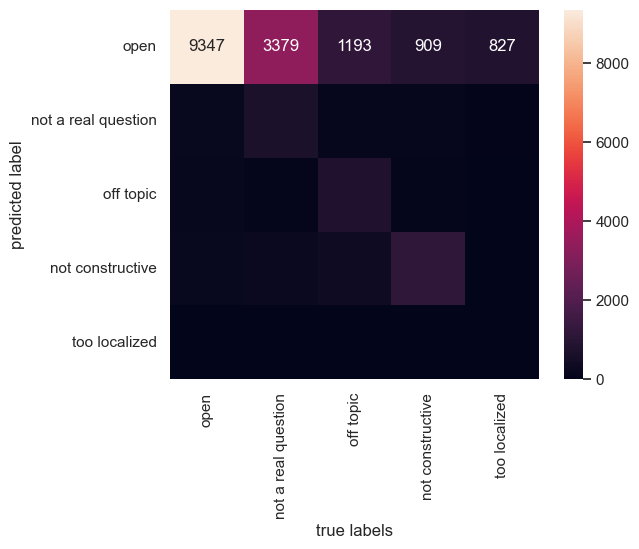

In [98]:
# Используем стандартные методы оценки характеристик классификации
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix 
import matplotlib.pyplot as plt 
import seaborn as sns 

mat = confusion_matrix(ytest, predicted_NB)

print('Classification Report \n', classification_report(ytest, predicted_NB))

sns.heatmap(mat.T, square=True, annot=True, fmt="d", xticklabels=categories, yticklabels=categories)
plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.show()

Ещё тут какая-то проблема с seaborn, почему-то только для первой строчки выводятся значения

Теперь пробуем с логистической регрессией, но используя пайплайн, чтобы не делать руками векторизацию

In [99]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

model = make_pipeline(TfidfVectorizer(), LogisticRegression(max_iter=1000)) # снова максимально простой пайплайн без подбора гиперпараметров
model.fit(xtrain, ytrain)
predicted_categories = model.predict(xtest)

Classification Report 
               precision    recall  f1-score   support

           0       0.67      0.87      0.76      9926
           1       0.54      0.39      0.46      4385
           2       0.60      0.46      0.52      2472
           3       0.61      0.53      0.57      2280
           4       0.32      0.03      0.05       937

    accuracy                           0.64     20000
   macro avg       0.55      0.46      0.47     20000
weighted avg       0.61      0.64      0.61     20000



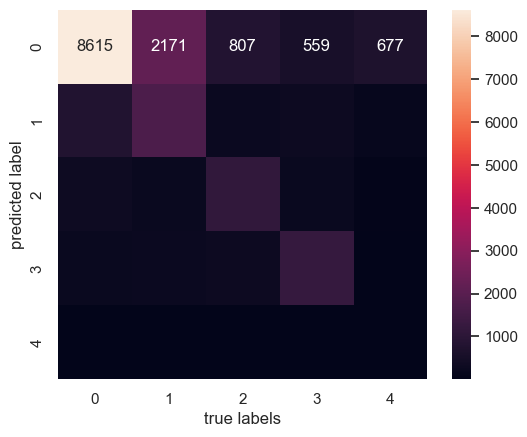

In [100]:
print('Classification Report \n', classification_report(ytest, predicted_categories))
mat = confusion_matrix(ytest, predicted_categories)
sns.heatmap(mat.T, square=True, annot=True, fmt="d")
plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.show()

Можно попробовать заложить в tf-idf параметры, которые отбросят слишком часто используемые слова. Ещё можно сразу воспользоваться на уровне tf-idf стоп-словами английского языка 

In [101]:
model = make_pipeline(TfidfVectorizer(stop_words='english',max_df=0.8, min_df = 0.0001), LogisticRegression(max_iter=1000))
model.fit(xtrain, ytrain)
predicted_categories = model.predict(xtest)

Classification Report 
               precision    recall  f1-score   support

           0       0.67      0.86      0.75      9926
           1       0.52      0.39      0.45      4385
           2       0.60      0.47      0.53      2472
           3       0.60      0.50      0.55      2280
           4       0.34      0.02      0.05       937

    accuracy                           0.63     20000
   macro avg       0.55      0.45      0.46     20000
weighted avg       0.61      0.63      0.60     20000



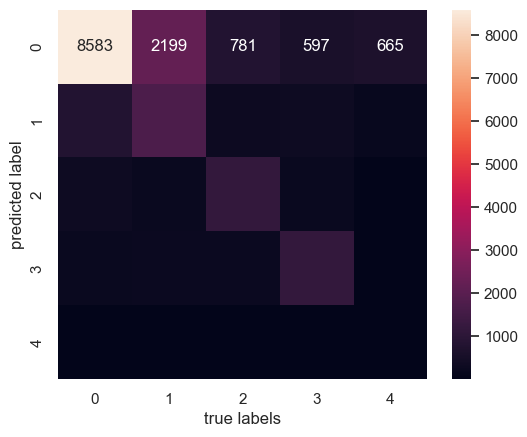

In [102]:
print('Classification Report \n', classification_report(ytest, predicted_categories))
mat = confusion_matrix(ytest, predicted_categories)
sns.heatmap(mat.T, square=True, annot=True, fmt="d")
plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.show()

Результата никакого... Можно попробовать предобработку текстов как было в лекции.

In [103]:
# Чтобы проверить предобработку пришлось сильно сократить датасет, иначе долго считает, быстро что-то проверять не удобно
data_train = data_train.sample(20000, random_state = 2)

x = data_train['Title'] + ' '+ data_train['BodyMarkdown']
y = data_train['OpenStatus']


data = pd.DataFrame(x,columns=['text'])

In [74]:
import spacy
nlp = spacy.load("en_core_web_sm")

data['cleaned_text'] = data['text'].apply(
    lambda x: ' '.join(
        token.lemma_.lower() for token in nlp(x) if 
        not token.is_stop 
        and not token.is_punct
        and not token.is_digit
        and not token.like_email
        and not token.like_num
        and not token.is_space
    )
)
data.sample(5)

,text,cleaned_text
139251,SIFR vs Cufon vs Typeface.js With browser supp...,sifr vs cufon vs typeface.js browser support l...
71490,"Origin of ""://"" in many URI syntaxes Anybody k...",origin uri syntax anybody know come uris synta...
42039,Facebook Timeline - how to convert to older pr...,facebook timeline convert old profile accident...
137936,Increment capacity in stack class java im usin...,increment capacity stack class java m stack ja...
7101,nHibernate - Objects or ObjectID's in classes ...,nhibernate objects objectid class migrate curr...


Classification Report 
               precision    recall  f1-score   support

           0       0.65      0.87      0.74      1977
           1       0.47      0.35      0.40       837
           2       0.60      0.39      0.47       527
           3       0.62      0.51      0.56       460
           4       0.11      0.01      0.01       199

    accuracy                           0.61      4000
   macro avg       0.49      0.42      0.44      4000
weighted avg       0.57      0.61      0.58      4000



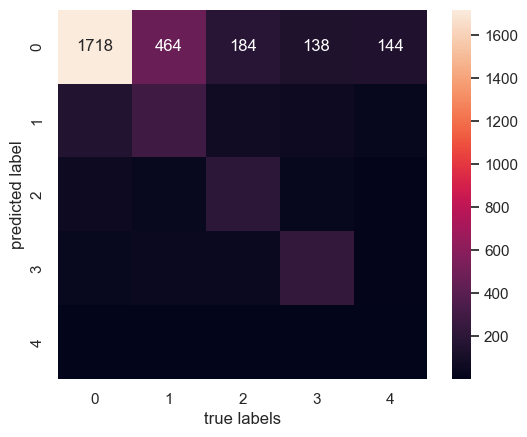

In [75]:
x_clean = data['cleaned_text']
y_clean = y

xtrain, xtest, ytrain, ytest = train_test_split(x_clean, y_clean, test_size = 0.2, random_state = 2)

model = make_pipeline(TfidfVectorizer(stop_words='english',max_df=0.8, min_df = 0.001), LogisticRegression(max_iter=1000)) 
model.fit(xtrain, ytrain)
predicted_categories = model.predict(xtest)


print('Classification Report \n', classification_report(ytest, predicted_categories))
mat = confusion_matrix(ytest, predicted_categories)
sns.heatmap(mat.T, square=True, annot=True, fmt="d")
plt.xlabel("true labels")
plt.ylabel("predicted label")
plt.show()

Либо я что-то делаю не так, либо на классификцию обработка текста не повлияла